In [93]:
# default_exp core

# Intent classifier (airedale)


## Motivation


![app](assets/app_french_2.png)







![serach pipeline](assets/Weak_Supervision_Lighting_Talk_-_Google_Slides.png)

## Task



Text Classification



![](assets/Intent_Pipeline.png)

## Setup

In [94]:
# !pip install yapf jupyter_contrib_nbextensions -q
# !jupyter contrib nbextension install --user 
# !jupyter nbextension enable codefolding/main 
# !jupyter nbextension enable scratchpad/main
# !jupyter nbextension enable code_prettify/code_prettify
# !jupyter nbextension enable toc2/main
# !jupyter nbextension enable execute_time/ExecuteTime
# !jupyter nbextension enable collapsible_headings/main

In [95]:
!pip install --upgrade pip -q
!pip install --upgrade -q \
    fsspec>=0.3.3 \
    s3fs>=0.3.0 \
    pyarrow \
    dask==2.14.0 \
    distributed==2.14.0 \
    pandas==0.25.0 \
    tqdm \
    snorkel \
    scikit-learn \
    pathos \
    nbdev


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-transform 0.15.0 requires tensorflow<2.2,>=1.15, which is not installed.
tfx-bsl 0.15.0 requires pyarrow<0.15.0,>=0.14.0, but you'll have pyarrow 1.0.0 which is incompatible.
apache-beam 2.23.0 requires dill<0.3.2,>=0.3.1.1, but you'll have dill 0.3.2 which is incompatible.
apache-beam 2.23.0 requires pyarrow<0.18.0,>=0.15.1; python_version >= "3.0" or platform_system != "Windows", but you'll have pyarrow 1.0.0 which is incompatible.


In [96]:
# %load_ext autoreload
# %autoreload 2

In [97]:
#hide
from nbdev.showdoc import *

In [98]:
# export
import csv
import os
import sys
import math
from collections import Counter

import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster #KEY!!

from intent_clf_airedale.gibberish_detector import *
from intent_clf_airedale.utils import *
from intent_clf_airedale.constants import *

In [99]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', -1)

### Dask Cluster

For this demo we will use only 1 node

In [100]:
cluster = LocalCluster(ip="0.0.0.0")
client = Client(cluster)
cluster 
#c4.8xl has 18 cores and 32vcores
#m4.10xl has 20 cores

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


## ETL



Extract all of the data sources we will need for labeling functions:

* knowledge bases
* pre-trained models
* keyword lists


and the unlabeled raw search queries

All ETL is against data lake and powered by Dask

In [101]:
from intent_clf_airedale.ETL import *

In [102]:
# export
LABEL_SET = ["CUISINE", "DISH", "RESTAURANT", "ADDRESS", "DIET", "ALCOHOL", "TOBACCO", "MEAL_TIME", "OTHER"]
LABEL_MAPPING = {label:i for i, label in enumerate(LABEL_SET)}
ABSTAIN=-1
LABEL_MAPPING

INV_LABEL_MAPPING={v: k for k,v in LABEL_MAPPING.items()}
INV_LABEL_MAPPING.update({-1: "ABSTAIN"})
INV_LABEL_MAPPING

{0: 'CUISINE',
 1: 'DISH',
 2: 'RESTAURANT',
 3: 'ADDRESS',
 4: 'DIET',
 5: 'ALCOHOL',
 6: 'TOBACCO',
 7: 'MEAL_TIME',
 8: 'OTHER',
 -1: 'ABSTAIN'}

In [103]:
merchant_set = extract_restaurants()
cuisine_set = extract_cuisines()
dish_set = extract_dishes()
team_kb = extract_team_labels(KB_PATH, LABEL_SET)
merchant_heuristics_set = extract_merchant_heuristics(MERCHANT_HEURISTICS_PATH)
intent_1000k_kb = extract_spelling_and_intent_1000(SPELLING_AND_INTENT_1000_MODIFIED)
dev_ddf = dd.from_pandas(extract_dev_set(KB_PATH, LABEL_MAPPING), npartitions=1)
df_test = extract_test_set(TEST_SET_PATH, LABEL_SET)

cuisine_set_resolved, dish_set_resolved, merchant_set_resolved = resolve_conflicts(
    cuisine_set, dish_set, merchant_set)
len(cuisine_set), len(cuisine_set_resolved)

(166, 203)

In [182]:
cnt_ddf = extract_search_query_text(START, END)
cnt_ddf = cnt_ddf.persist()
cnt_ddf.npartitions

175


105

In [105]:
pdf_train = cnt_ddf.compute()

## Weak Supervision



1. First we will define our labeling functions
1. Then we will map our labeling functions across the queries w/ Dask


![](assets/snorkel.png)

### Label Functions

In [106]:
from snorkel.labeling import labeling_function, PandasLFApplier
from snorkel.augmentation import transformation_function
from snorkel.labeling.apply.dask import DaskLFApplier, PandasParallelLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling import LabelingFunction

In [107]:
# export

import re


def address(x, futures):

    normd_query = x["query"].lower()

    if len(normd_query) > 32:
        return ABSTAIN

    exp = '\d{1,4} [\w\s]{1,20}(?:street|st|avenue|ave|road|rd|highway|hwy|square|sq|trail|trl|drive|dr|court|ct|parkway|pkwy|circle|cir|boulevard|blvd)\W?(?=\s|$)'
    regex = re.compile(exp, re.IGNORECASE)

    if regex.search(normd_query):
        return LABEL_MAPPING['ADDRESS']
    else:
        return ABSTAIN


#@labeling_function(resources=dict(dishes=dish_set))
def dish_keyword_match(query, futures, dishes):
    normd_query = query["query"].lower()
    tokens = normd_query.split()

    if len(normd_query) > 34: 
        return ABSTAIN

    for keyword in dishes:
        if keyword in normd_query:
            return LABEL_MAPPING['DISH']
        elif keyword[-1] == "s":
            keyword_singular = keyword[:-1]
            ratio = len(keyword_singular) / len(normd_query)
            threshold = .8
            if keyword[:-1] in normd_query and ratio > threshold:  #remove s (plural)
                return LABEL_MAPPING['DISH']
    else:
        return ABSTAIN


def cuisine_exact_match(query, futures, cuisine_set):
    normd_query = query["query"].lower()

    if len(normd_query) > 20:
        return ABSTAIN

    if normd_query in cuisine_set:
        return LABEL_MAPPING['CUISINE']
    else:
        return ABSTAIN


def cuisine_fuzzy_match(query, futures, cuisine_set):
    normd_query = query["query"].lower()
    tokens = normd_query.split()

    if len(
            tokens
    ) >= 2:  
        return ABSTAIN
    if len(normd_query) > 20:
        return ABSTAIN


    for cuisine in list(cuisine_set):
        if cuisine in normd_query:
            return LABEL_MAPPING['CUISINE']
        elif cuisine[-1] == "s":  #strip plural
            if cuisine[:-1] in normd_query:
                return LABEL_MAPPING['CUISINE']
    return ABSTAIN


# def search_cuisines_match(x, futures, search_cuisines):
#     normd_query = x["query"].lower()

#     if normd_query in search_cuisines:
#         return LABEL_MAPPING['CUISINE']
#     else:
#         return ABSTAIN


def restaurant_exact_match_(query, futures):

    normd_query = query["query"].lower()

    merchant_set = futures

    if not merchant_set:  #for tests
        return None

    #this is a tough (high-precision) exact string match...
    if normd_query in merchant_set:
        return LABEL_MAPPING['RESTAURANT']
    else:
        return ABSTAIN


def _dataset_matcher(x, futures, kb):

    normd_query = x["query"].lower()

    if normd_query in kb:
        return LABEL_MAPPING[kb[normd_query]]
    else:
        return ABSTAIN


def alcohol_lf(x, futures, alcohol_set):

    normd_query = x["query"].lower()

    if normd_query in alcohol_set:
        return LABEL_MAPPING["ALCOHOL"]
    else:
        return ABSTAIN


def tobacco_lf(x, futures, tobacco_set):

    normd_query = x["query"].lower()

    if normd_query in tobacco_set:
        return LABEL_MAPPING["TOBACCO"]
    else:
        return ABSTAIN


def diet_lf(x, futures, diet_set):

    normd_query = x["query"].lower()

    if normd_query in diet_set:
        return LABEL_MAPPING["DIET"]
    else:
        return ABSTAIN


def mealtime_lf(x, futures, mealtime_set):

    normd_query = x["query"].lower()

    if normd_query in mealtime_set:
        return LABEL_MAPPING["MEAL_TIME"]
    else:
        return ABSTAIN


def merchant_heuristics_lf(x, futures, rest_token_list):
    """
    """

    normd_query = x["query"].lower()
    tokens = normd_query.split()

    #
    if len(tokens) >= 10:
        return ABSTAIN

    #
    for keyword in rest_token_list:
        if keyword in tokens:
            return LABEL_MAPPING['RESTAURANT']
    else:
        return ABSTAIN


import pickle
model_data = pickle.load(open('gib_model.pki', 'rb'))
model_mat = model_data['mat']
threshold = model_data['thresh']


def gibberish_detector(x, futures):

    normd_query = x["query"].lower()

    skip_list = [
    ]
    if normd_query in skip_list:
        return ABSTAIN

    score = avg_transition_prob(normd_query, model_mat)

    if score < .005:
        return LABEL_MAPPING["OTHER"]
    else:
        return ABSTAIN



def H(s):
    """string char cross entropy"""
    probabilities = [n_x / len(s) for x, n_x in Counter(s).items()]
    e_x = [-p_x * math.log(p_x, 2) for p_x in probabilities]
    return sum(e_x)


def entropy_detector(x, futures):

    normd_query = x["query"].lower()

    h = H(normd_query)
    THRES = 0.9

    if h < THRES:
        return LABEL_MAPPING["OTHER"]
    else:
        return ABSTAIN

def team_1k_kb_matcher(x, futures, kb):

    normd_query = x["query"].lower()

    if normd_query in kb:
        return LABEL_MAPPING[kb[normd_query]]
    else:
        return ABSTAIN

In [108]:
from intent_clf_airedale.dask_monkey_patches import *

In [109]:
#hide

merch_lf = __LabelingFunction("merchant_distance_kb", restaurant_exact_match_)
address = __LabelingFunction("address_match", address)
dish_match = __LabelingFunction("dish_keyword_match", dish_keyword_match, resources={"dishes":dish_set_resolved})
cuisine_match = __LabelingFunction("cusine_match", cuisine_exact_match, resources={"cuisine_set":cuisine_set_resolved})
team_kb_lf = __LabelingFunction("team_kb_lf", _dataset_matcher, resources={"kb": team_kb})
alcohol_lf = __LabelingFunction("alcohol_lf", alcohol_lf, resources={"alcohol_set": ALCOHOL_TOKENS})
tobacco_lf = __LabelingFunction("tobacco_lf", tobacco_lf, resources={"tobacco_set": TOBACCO_TOKENS})
diet_lf = __LabelingFunction("diet_lf", diet_lf, resources={"diet_set": DIET_TOKENS})
mealtime_lf = __LabelingFunction("mealtime_lf", mealtime_lf, resources={"mealtime_set": MEAL_TIME_TOKENS})
merchant_heuristics_lf = __LabelingFunction("merchant_heuristics_lf", merchant_heuristics_lf, resources={"rest_token_list": merchant_heuristics_set})
gibberish_lf = __LabelingFunction("gibberish_det_lf", gibberish_detector)
entropy_lf = __LabelingFunction("entropy_det_lf", entropy_detector)
intent_1k_kb_lf = __LabelingFunction("team_1k_kb_lf", team_1k_kb_matcher, resources={"kb": intent_1000k_kb})

In [110]:
lfs = [
    address,
    dish_match,
    cuisine_match,
    merch_lf,
    team_kb_lf,
    alcohol_lf,
    tobacco_lf,
    diet_lf,
    mealtime_lf,
    merchant_heuristics_lf,
    gibberish_lf,
    entropy_lf,
    intent_1k_kb_lf
]

In [111]:
def test_labelers(query):
    for lf in lfs:
        x = {"query": query}
        match_flag = lf(x)
        print("{:>30s} {} {}".format(
            lf.name, match_flag,
            ("✅ {}".format(LABEL_SET[match_flag]) if match_flag != -1 and match_flag != None else "")))

In [183]:
test_labelers("sushi")

                 address_match -1 
            dish_keyword_match -1 
                  cusine_match 0 ✅ CUISINE
          merchant_distance_kb None 
                    team_kb_lf 1 ✅ DISH
                    alcohol_lf -1 
                    tobacco_lf -1 
                       diet_lf -1 
                   mealtime_lf -1 
        merchant_heuristics_lf -1 
              gibberish_det_lf -1 
                entropy_det_lf -1 
                 team_1k_kb_lf 1 ✅ DISH


In [113]:
cnt_ddf.count().compute() 

query    282486
count    282486
len      282486
dtype: int64

### Map Snorkel 

In [114]:
from snorkel.labeling.apply.dask import rows_to_triplets
from snorkel.labeling import LFAnalysis

In [115]:
#apply monkey patches
from intent_clf_airedale.dask_monkey_patches import *

#monkey patch
LabelingFunction = __LabelingFunction
DaskLFApplier.apply = __apply
apply_lfs_to_data_point = __apply_lfs_to_data_point

In [116]:
#broadcast large data
[merchant_set_future] = client.scatter([merchant_set_resolved], broadcast=True)
merchant_set_future

<Future: finished, type: builtins.set, key: set-8931decffa979329bf2d585c9c7d33bd>

In [184]:
%%time
applier = DaskLFApplier(lfs)
L_dev = applier.apply(dev_ddf, client, futures=merchant_set_future)
L_train = applier.apply(cnt_ddf, client, futures=merchant_set_future)


CPU times: user 27.2 s, sys: 2.24 s, total: 29.4 s
Wall time: 2min 20s


In [185]:
L_train

array([[-1,  1, -1, ..., -1, -1, -1],
       [-1,  1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1,  1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [118]:
Y_dev=dev_ddf.compute().label.values
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y_dev)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[-1  0  1  2  3  4  5  7  8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
address_match,0,[3],0.00,0.00,0.00,5,0,1.00
dish_keyword_match,1,[1],0.51,0.51,0.15,442,117,0.79
cusine_match,2,[0],0.06,0.06,0.03,43,27,0.61
merchant_distance_kb,3,[2],0.26,0.26,0.11,217,71,0.75
team_kb_lf,4,"[0, 1, 2, 3, 4, 5, 7, 8]",1.00,0.81,0.22,1104,1,1.00
alcohol_lf,5,[5],0.00,0.00,0.00,3,0,1.00
tobacco_lf,6,[],0.00,0.00,0.00,0,0,0.00
diet_lf,7,[4],0.01,0.01,0.00,5,3,0.62
mealtime_lf,8,[7],0.00,0.00,0.00,2,2,0.50
merchant_heuristics_lf,9,[2],0.11,0.11,0.04,116,11,0.91


In [119]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary() 

,j,Polarity,Coverage,Overlaps,Conflicts
address_match,0,[3],0.01,0.00,0.00
dish_keyword_match,1,[1],0.24,0.06,0.05
cusine_match,2,[0],0.00,0.00,0.00
merchant_distance_kb,3,[2],0.18,0.08,0.04
team_kb_lf,4,"[0, 1, 2, 3, 4, 5, 7, 8]",0.00,0.00,0.00
alcohol_lf,5,[5],0.00,0.00,0.00
tobacco_lf,6,[6],0.00,0.00,0.00
diet_lf,7,[4],0.00,0.00,0.00
mealtime_lf,8,[7],0.00,0.00,0.00
merchant_heuristics_lf,9,[2],0.18,0.08,0.03


In [120]:
print(f"Training set coverage: {100 * LFAnalysis(L_train).label_coverage(): 0.1f}%")
print(f"Dev set coverage: {100 * LFAnalysis(L_dev).label_coverage(): 0.1f}%")

Training set coverage:  49.8%
Dev set coverage:  100.0%


### Label Model

Label function might conflict or even correlate. How do you choose the final label for a doc when there are so many in competition?

In [121]:
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
from snorkel.analysis import metric_score

In [122]:
label_model = LabelModel(cardinality=len(LABEL_SET))
label_model.fit(L_train)

As a spot-check for the quality of our LabelModel, we’ll score it on the dev set.

In [123]:
probs_train = label_model.predict_proba(L=L_train) #soft labels for sparse x-ent
preds_dev = label_model.predict(L_dev) #hard labels for xent

acc = metric_score(Y_dev, preds_dev, probs=None, metric="accuracy")
print(f"LabelModel Accuracy: {acc:.3f}")

LabelModel Accuracy: 0.985


We see that we get very high accuracy on the development set. This is due to the abundance of high quality labeling functions. **Since we don’t have these high quality labeling functions for the test set or new incoming data points, we can’t use the LabelModel reliably at inference time.** In order to run inference on new incoming data points, we need to train a discriminative model over the queries themselves. Let’s generate a set of labels for that training set.

In [124]:
#Filter out examples not covered by any labeling function.
pdf_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=pdf_train, y=probs_train, L=L_train)

In [125]:
#Convert an array of probabilistic labels into an array of predictions. ie hard labels for x-ent
labels_train_filtered = probs_to_preds(probs_train_filtered, "abstain")

In [126]:
#update querires dataframe w/ the hard and soft labels
pdf_train_filtered["label"]=labels_train_filtered
pdf_train_filtered["prob_labels"] = np.around(probs_train_filtered,2).tolist()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [127]:
%store -r
version = version+1
%store version
version

Stored 'version' (int)


17

In [128]:
version = "v"+str(version)
dataset_path="data/{version}".format(version=version)
!mkdir -p "{dataset_path}"

In [129]:
pdf_train_filtered.to_csv("{}/datast.csv".format(dataset_path), index=False)
pdf_train_filtered.to_parquet("{}/dataset.parquet".format(dataset_path))

## Modeling

In [130]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight

In [131]:
#post processing -- remove tail queries
#TODO move this below the the imbalance secsion
pdf_train_trunc = truncate_tail(pdf_train_filtered)
pdf_train_filtered.shape[0], pdf_train_trunc.shape[0]

(140604, 18339)

In [132]:
path = "{}/dataset.parquet".format(dataset_path)

pdf = pd.read_parquet(path.format(version))
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140604 entries, 0 to 282811
Data columns (total 5 columns):
query          140604 non-null object
count          140604 non-null int64
len            140604 non-null int64
label          140604 non-null int64
prob_labels    140604 non-null object
dtypes: int64(3), object(2)
memory usage: 6.4+ MB


words per sample: 2.0


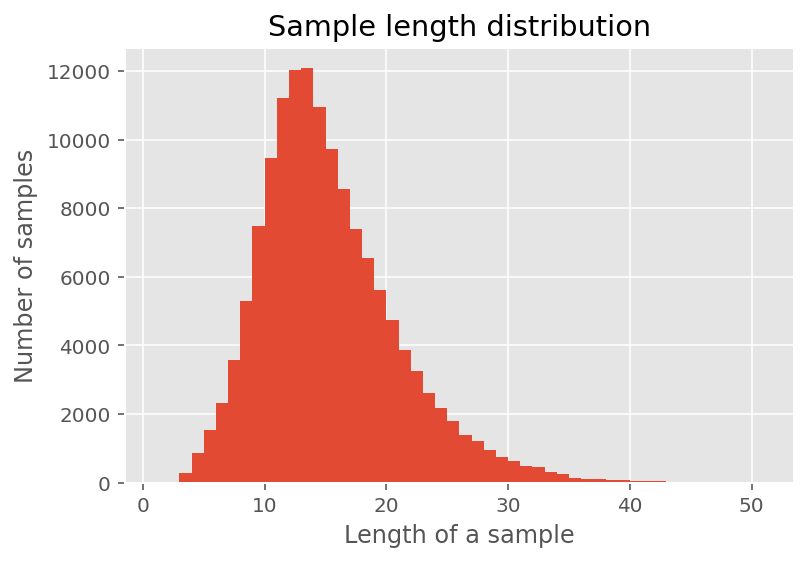

In [133]:
wps = get_num_words_per_sample(pdf["query"])
print("words per sample:", wps)
plot_sample_length_distribution(pdf["query"], bins=50)

In [134]:
S_W_THRESHOLD = 1500
s_w_ratio = pdf.shape[0] / wps
print("s/w ratio is %F"%s_w_ratio)

if s_w_ratio < S_W_THRESHOLD:
    print("BOW ngram model")
else:
    print("sequential model")
    if s_w_ratio < 15000:
        print("\tuse pre-trained embedding")
    else:
        print("\tyou can prob train from scratch")

s/w ratio is 70302.000000
sequential model
	you can prob train from scratch


In [135]:
def counts_merge(pdf):
    return pd.merge(
        pdf.label.value_counts(normalize=False),
        pdf.label.value_counts(normalize=True),
        left_index=True,
        right_index=True,
        suffixes=("_cnt", "_p")
    )
counts_merge(pdf)

,label_cnt,label_p
2,84202,0.60
1,53894,0.38
3,1800,0.01
8,408,0.00
0,170,0.00
5,69,0.00
4,32,0.00
7,15,0.00
6,14,0.00


In [136]:
#post processing -- remove tail queries
#TODO move this below the the imbalance secsion
pdf_trunc = truncate_tail(pdf)
pdf.shape[0], pdf_trunc.shape[0]

counts_merge(pdf_train_trunc)

,label_cnt,label_p
1,8360,0.46
2,7471,0.41
3,1800,0.10
8,408,0.02
0,170,0.01
5,69,0.00
4,32,0.00
7,15,0.00
6,14,0.00


In [138]:
pdf = pdf_trunc

In [139]:
y_exploded = pdf.loc[pdf.index.repeat(pdf["count"])][["label"]].label.values #(518334,)

class_weights_smoothed = get_class_weights(Counter(y_exploded), smooth_factor=0.1) #dict

class_weights_smoothed_exploded = compute_sample_weight(class_weights_smoothed, pdf.label) #(4886,)

class_weights_list = compute_sample_weight('balanced', y=pdf.label.values) #(4886,)

counts = pdf["count"].values

sample_weights_composite = class_weights_smoothed_exploded * counts #(4886,)




# #add the sample weights to the dataset and save to disk:
pdf["class_weight"] = class_weights_smoothed_exploded
pdf["composite_sample_weight"] = sample_weights_composite

In [140]:
pdf.to_csv(os.path.join(dataset_path, "dataset+weights.csv"), index=False)
pdf.to_parquet(os.path.join(dataset_path, "dataset+weights.parquet"))

### Keras

In [141]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras import layers
import keras.optimizers
from keras import backend as K
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf


pd.set_option('display.float_format', lambda x: '%.2f' % x)

from intent_clf_airedale.fasttext import *

#!pip install -q keras_lr_finder
#!pip install git+https://github.com/google-research/google-research.git#subdirectory=opt_list -q
#from opt_list import tf_opt_list

In [142]:
from sklearn.preprocessing import OneHotEncoder

In [143]:
#format for sklearn and keras
sentences_train = pdf["query"].values
sentences_test = df_test["query"].values
y_train_soft=np.vstack(pdf.prob_labels.values) #soft labels
#y_test_soft=np.vstack(pdf.prob_labels.values) #soft labels
y_train_hard=pdf.label.values #hard labels 
y_test_hard = df_test.label.values

sentences_train.shape,  y_train_hard.shape, sentences_test.shape, y_test_hard.shape

((18339,), (18339,), (519,), (519,))

In [144]:
sparse_encoder = OneHotEncoder()
y_test_sparse = sparse_encoder.fit_transform(y_test_hard.reshape(-1, 1)).toarray()

In [145]:
tokenizer = Tokenizer(num_words=None, char_level=True, lower=True, )
tokenizer.fit_on_texts(sentences_train)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print("vocab size", vocab_size)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

vocab size 54
Average train sequence length: 12
Average test sequence length: 10


In [146]:
ngram_range = 3
max_features = vocab_size

In [147]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in X_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1
    print("new max_features", max_features)

    # Augmenting x_train and x_test with n-grams features
    X_train = add_ngram(X_train, token_indice, ngram_range)
    X_test = add_ngram(X_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, X_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
         np.mean(list(map(len, X_test)), dtype=int)))

maxlen=50
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

Adding 3-gram features
new max_features 9185
Average train sequence length: 34
Average test sequence length: 27


In [148]:
target_names = LABEL_SET

def MLP(input_dim):
    """
    No embeddings
    """
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(len(target_names), activation='softmax'))
    return model

def MaxPooling(vocab_size, embedding_dim = 50, activation="softmax", dropout=0.):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, 
                               embeddings_initializer='he_uniform'))
    model.add(layers.Dropout(dropout))    
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(len(target_names), activation=activation, kernel_initializer="he_uniform"))
    return model

def MetaMaxPooling(vocab_size, embedding_dim = 50, activation="softmax", dropout=0.):
    ngrams = layers.Input(shape=(maxlen,), name="ngrams_input")
    char_cnt = layers.Input(shape=(10,))
    
    emb = layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, 
                               embeddings_initializer='he_uniform')(ngrams)
    maxp = layers.GlobalMaxPooling1D()(emb)
    
    dense = layers.Dense(100, activation="relu")(char_cnt)
    dense_relu = layers.Dense(100, activation="relu")(dense)
    
    concat = layers.Concatenate()([maxp, dense_relu])
    output = layers.Dense(len(target_names), activation=activation, kernel_initializer="he_uniform")(maxp)

    model = Model(inputs=[ngrams], outputs=output)
    return model
    

def DNN(vocab_size, embedding_dim=50, activation="softmax", dropout=0.0):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.GlobalAveragePooling1D())
    
    model.add(layers.Dense(100, activation="relu"))
    model.add(layers.Dropout(dropout))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(len(target_names), activation=activation))
    return model

def CNN(embedding_dim = 50):
    

    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

    model.add(layers.SeparableConv1D(128, 3, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(len(target_names), activation='softmax'))
    return model

def LSTM(embedding_dim=50, dropout=0.0):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.SpatialDropout1D(dropout))
    model.add(layers.LSTM(100, dropout=dropout, recurrent_dropout=dropout))
    model.add(layers.Dense(len(target_names), activation='softmax'))
    return model
    
def Bi_LSTM(embedding_dim = 50):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dropout(0.0))
    model.add(layers.Dense(len(target_names), activation='softmax'))
    return model

def ConvLSTM(kernel_size = 5, filters = 64, pool_size = 4, lstm_output_size = 70, embedding_dim = 50):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(layers.MaxPooling1D(pool_size=pool_size))
    model.add(layers.LSTM(lstm_output_size))
    model.add(layers.Dense(len(target_names), activation="softmax"))
    return model


In [149]:
def build_model(single_label=True, hard_labels=True):
    activation = "softmax"
    if single_label:
        if hard_labels:
            loss = 'sparse_categorical_crossentropy'
        else:  #soft labels
            loss = 'categorical_crossentropy'
    else:  #multilabel
        print("multi-label")
        activation = "sigmoid"
        loss = 'categorical_crossentropy'


    model = MaxPooling(max_features,
                       embedding_dim=128,
                       activation=activation,
                       dropout=0.0)


    opt = keras.optimizers.Nadam()

    print(loss)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    model.summary()

    return model


#### Training

In [150]:
import tensorflow as tf

logger = tf.get_logger()
logger.propagate = False

sparse_categorical_crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 128)           1175680   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1161      
Total params: 1,176,841
Trainable params: 1,176,841
Non-trainable params: 0
_________________________________________________________________
Train on 18339 samples, validate on 519 samples
Epoch 1/50
18339/18339 [==============================] - 1s 48us/step - loss: 678.7662 - acc: 0.3615 - val_loss: 1.8023 - val_acc: 0.3218
Epoch 2/50
18339/18339 [=====================

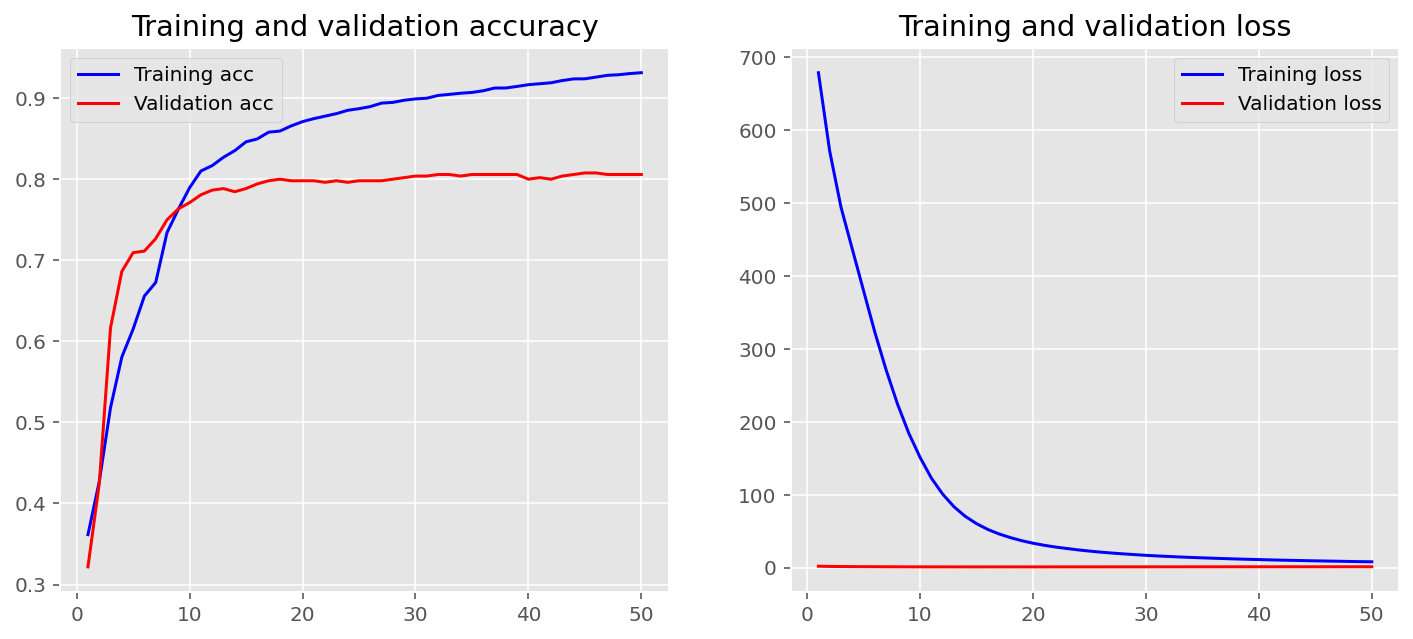

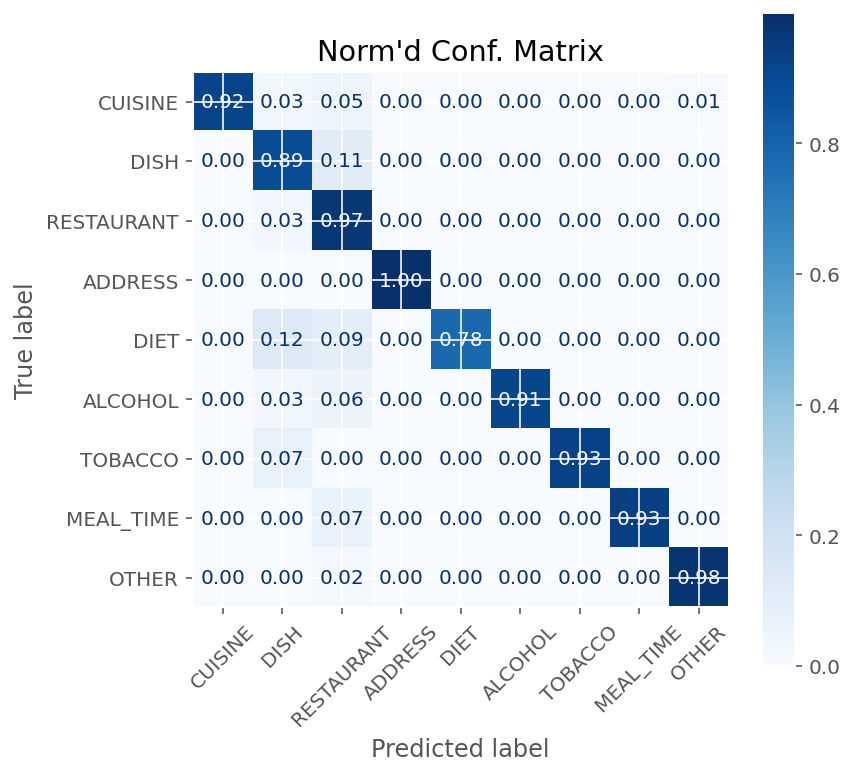

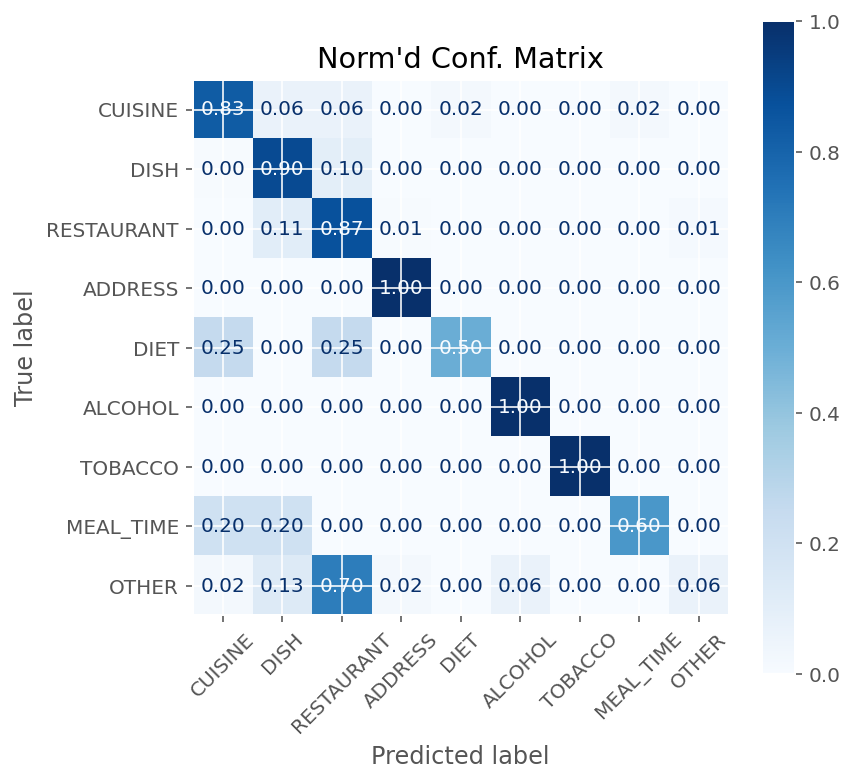

In [190]:
TRAIN_BATCH_SIZE = 512
training_steps = X_train_pad.shape[0] / TRAIN_BATCH_SIZE
EVAL_BATCH_SIZE = 4096
EPOCHS = 50

callbacks = [
    #    keras.callbacks.EarlyStopping(patience=2, monitor="val_acc", min_delta=1e-3)
]


weights = [
           #None, 
          #class_weights_list, 
          # class_weights_smoothed_exploded,
           #counts,  #THESE PASS THE FRENCH TEST
           class_weights_smoothed_exploded * counts
          ]

for sample_weights in weights:

    hard_labels=True
    model = build_model(single_label=True, hard_labels=hard_labels)
    if hard_labels:
        y_train = y_train_hard
        y_test = y_test_hard
    else:
        y_train = y_train_soft
        y_test = y_test_sparse

    history = model.fit(
        [X_train_pad],
        y_train,
        epochs=EPOCHS,
        validation_data=([X_test_pad], y_test),
        batch_size=TRAIN_BATCH_SIZE,
        sample_weight=sample_weights,
        callbacks=callbacks)
    
    plot_history(history)

    loss, accuracy = model.evaluate([X_train_pad],
                                    y_train,
                                    batch_size=EVAL_BATCH_SIZE,
                                    verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate([X_test_pad], y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    y_pred = np.argmax(model.predict([X_train_pad], batch_size=EVAL_BATCH_SIZE), axis=1)
    print(classification_report(
        y_train_hard,
        y_pred,
        target_names=target_names,
    ))
    __plot_confusion_matrix(y_train_hard, y_pred, target_names, "Norm'd Conf. Matrix")

    y_test_pred = np.argmax(model.predict([X_test_pad], batch_size=EVAL_BATCH_SIZE), axis=1)
    print(classification_report(
        y_test_hard,
        y_test_pred,
        target_names=target_names,
    ))
    __plot_confusion_matrix(y_test_hard, y_test_pred, target_names,
                           "Norm'd Conf. Matrix")

#### Testing

In [191]:
vectorize_pipe = lambda x: pad_sequences(add_ngram(tokenizer.texts_to_sequences(x), token_indice, ngram_range), padding='post', maxlen=maxlen)
vectorize_pipe(["pizza"])

array([[  16,    4,   24,   24,    3, 6158, 4771, 2098, 6540,  934, 4826,
        2836,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

TOBACCO [[0.02 0.   0.16 0.04 0.01 0.   0.74 0.01 0.01]]


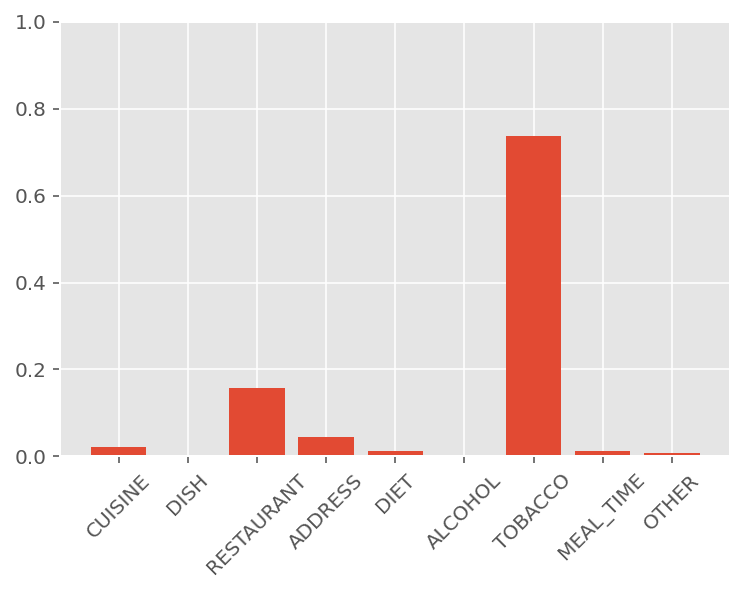

In [192]:
query = "cigaretes"
probs = model.predict([vectorize_pipe([query])])
print(INV_LABEL_MAPPING[np.argmax(probs)], probs)

_=plt.bar(range(len(LABEL_SET)),probs[0],)
_=plt.xticks(range(len(LABEL_SET)), LABEL_SET, rotation=45)
_=plt.ylim(top=1.)

In [154]:
input_examples = ["taco bell", "taco ball", "KFC", "sushi", "hancos", "le prive", "le rivage", "starbuck coffe",
                 "z", "zz", "zzz", "j", "jj", "asdf", "beer", "juul", "paleo pizza", "pizza", "paleo",
                 "gluten free pizza", "french", "beef bourginion", "mcdonalds", "mcd",
                  "cheesecake", "zzzzzzz", "wine", "vodka", "pizza",
                 "", " ", "mediterian", "jsalfjsalfkj", "carnitas snack shack", "panera", "wine", "lunch",
                 "vegan sandwitch", "bhel puri", "french", "frennch", "crench", "frennc"]

In [155]:
#test set

test_preds=model.predict(vectorize_pipe(input_examples))
list(zip(input_examples, [INV_LABEL_MAPPING[klass] for klass in np.argmax(test_preds, axis=1)]))

[('taco bell', 'RESTAURANT'),
 ('taco ball', 'RESTAURANT'),
 ('KFC', 'RESTAURANT'),
 ('sushi', 'DISH'),
 ('hancos', 'RESTAURANT'),
 ('le prive', 'RESTAURANT'),
 ('le rivage', 'RESTAURANT'),
 ('starbuck coffe', 'RESTAURANT'),
 ('z', 'OTHER'),
 ('zz', 'DIET'),
 ('zzz', 'OTHER'),
 ('j', 'OTHER'),
 ('jj', 'OTHER'),
 ('asdf', 'CUISINE'),
 ('beer', 'ALCOHOL'),
 ('juul', 'TOBACCO'),
 ('paleo pizza', 'DIET'),
 ('pizza', 'DISH'),
 ('paleo', 'DIET'),
 ('gluten free pizza', 'DIET'),
 ('french', 'CUISINE'),
 ('beef bourginion', 'RESTAURANT'),
 ('mcdonalds', 'RESTAURANT'),
 ('mcd', 'RESTAURANT'),
 ('cheesecake', 'DISH'),
 ('zzzzzzz', 'OTHER'),
 ('wine', 'ALCOHOL'),
 ('vodka', 'ALCOHOL'),
 ('pizza', 'DISH'),
 ('', 'OTHER'),
 (' ', 'RESTAURANT'),
 ('mediterian', 'CUISINE'),
 ('jsalfjsalfkj', 'OTHER'),
 ('carnitas snack shack', 'DISH'),
 ('panera', 'RESTAURANT'),
 ('wine', 'ALCOHOL'),
 ('lunch', 'MEAL_TIME'),
 ('vegan sandwitch', 'RESTAURANT'),
 ('bhel puri', 'RESTAURANT'),
 ('french', 'CUISINE'),
 ('

In [156]:
export_path = "exports/keras/{}".format(version)

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_query': model.input},
    outputs={t.name: t for t in model.outputs}
)

In [157]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

W0730 20:32:36.847273 140092751234880 module_wrapper.py:139] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_query'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 50)
      name: embedding_2_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2/Softmax:0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 9)
      name: dense_2/Softmax:0
Method name is: tensorflow/serving/predict


### Tensorflow



#### Train/Test Skew

![](assets/skew.png)

#### In-graph Ops
![](assets/no_skew.png)

In [158]:
!pip install tensorflow-metadata==0.15 pydot==1.2.4 tfx-bsl==0.15 absl-py==0.7
!pip install tensorflow-transform==0.15.0 -q --no-deps
!pip install git+https://github.com/google-research/google-research.git#subdirectory=opt_list -q

Looking in indexes: https://artifactory.gdp.data.grubhub.com/artifactory/api/pypi/pypi/simple
     |████████████████████████████████| 58.1 MB 167 kB/s  eta 0:00:01
Processing /home_local/ubuntu/.cache/pip/wheels/2e/3c/53/c0f133910baebb80f6ccfaa8051bbcafb4eb09a0e4b362af68/dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 1.0.0
    Uninstalling pyarrow-1.0.0:
      Successfully uninstalled pyarrow-1.0.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.2
    Uninstalling dill-0.3.2:
      Successfully uninstalled dill-0.3.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-transform 0.15.0 requires tensorflow<2.2,>=1.15, which is not installed.
pathos 0.2.6 requir

In [159]:
import os
import random
import math
import logging


import numpy as np

import tensorflow as tf
import tensorflow_transform as tft

print(tf.__version__)
print(tft.__version__)


from tensorflow.gfile import Glob
from opt_list import tf_opt_list
# import tensorflow_text as text

import pandas as pd
#classification metrics
from sklearn.metrics import classification_report

from intent_clf_airedale.TF_data import *

# import mlflow

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

1.15.2
0.15.0


#### Data

In [160]:
train_dataset_path = "data/{}/dataset+weights.csv".format(version)

In [161]:
df_train = pd.read_csv(train_dataset_path)
!head '{train_dataset_path}'

query,count,len,label,prob_labels,class_weight,composite_sample_weight
#1 chop suey,5,12,1,[0.03 0.63 0.15 0.03 0.03 0.03 0.03 0.03 0.03],1.0,5.0
$10 off first time offer,1,24,3,[0.08 0.07 0.12 0.36 0.08 0.08 0.08 0.08 0.08],10.823441780605739,10.823441780605739
& pizza,37,7,2,[0.08 0.09 0.35 0.08 0.08 0.08 0.08 0.08 0.08],1.7059111044220585,63.118710863616165
&pizza,217,6,2,[0.06 0.23 0.37 0.06 0.06 0.06 0.06 0.06 0.06],1.7059111044220585,370.1827096595867
1 international dr,2,18,3,[0.08 0.07 0.12 0.36 0.08 0.08 0.08 0.08 0.08],10.823441780605739,21.646883561211478
1 lb carnitas,6,13,1,[0.09 0.27 0.11 0.09 0.09 0.09 0.09 0.09 0.09],1.0,6.0
1 liter diet coke,11,17,1,[0.09 0.27 0.11 0.09 0.09 0.09 0.09 0.09 0.09],1.0,11.0
1 wedgewood dr verona nj 07044,5,30,3,[0.08 0.07 0.12 0.36 0.08 0.08 0.08 0.08 0.08],10.823441780605739,54.1172089030287
1/2 chicken,5,11,1,[0.09 0.27 0.11 0.09 0.09 0.09 0.09 0.09 0.09],1.0,5.0


In [162]:
#ds = dataset([train_dataset_path], 1024, tokenizer_mode=TokenizationModes.CHAR, take=False) #this is kinda slow b/c I think make_csv_dataset reads the data to learn some stats
ds = make_dataset(train_dataset_path, 512, len(LABEL_SET), tokenizer_mode=TokenizationModes.CHAR, shuffle=True)
iterator = ds.make_one_shot_iterator().get_next()
iterator

({'query': <tf.Tensor 'IteratorGetNext_3:0' shape=(?,) dtype=string>,
  'slen': <tf.Tensor 'IteratorGetNext_3:1' shape=(?,) dtype=int32>,
  'weight': <tf.Tensor 'IteratorGetNext_3:3' shape=(?,) dtype=float64>,
  'tokens': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fc034a3f160>,
  'word_tokens': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fc0349f9828>},
 <tf.Tensor 'IteratorGetNext_3:5' shape=(?, 9) dtype=float32>)

In [163]:
%%time
i=0
with tf.Session() as sess:
    while True:
        try:
            batch = sess.run(iterator)
            #break
            if i%1000==0:
                print(i)
            i+=1
        except tf.errors.OutOfRangeError:
            break
            
print(i)


N=i
N

0
36
CPU times: user 1.2 s, sys: 136 ms, total: 1.34 s
Wall time: 668 ms


36

In [164]:
batch[0]

{'query': array([b'taylor made burgers', b'king?s burgers',
        b'101 algonquin rd 10710', b'11 leatherwood drive', b'schlafly',
        b'6602 ridge ave', b'lengua burrito', b'spice',
        b'bed -stuy fish fry', b'5480 barrett avenue', b'hook and fish',
        b'yakisoba', b"jc's", b'139 georgetown road', b'16001 jamaica ave',
        b'825 west 181st st, ny, nu', b'j.p.', b'131 ocean ave 1',
        b'81 park ave danbury ct', b'5325 fox ridge rd roanoke va',
        b'497 meeker ave', b'crab cooker', b"junior's", b'wolfies',
        b'1202 5th avenue', b'buena beef',
        b'2122 us highway auburndale fl', b'9201 4th ave', b'spirit',
        b'13827 shirley ct', b'8501 henry ave q5', b'douglas burger',
        b'176 palisade ave', b'empanada mana',
        b'2110 montiel rd san marcos', b"c'est si bon pastry",
        b'papa nadas 2268 west 7th', b'c&js', b'two meatballs',
        b'salmon rice', b'5447 ne 42nd ave', b'taste buds', b'fresh wings',
        b'p.j.', b'3336 wo

In [165]:
%%time

build_write_vocab(train_dataset_path, min_count=0)

9183
CPU times: user 1 s, sys: 66.6 ms, total: 1.07 s
Wall time: 990 ms


In [166]:
!wc -l data/vocab #17932

9183 data/vocab


In [167]:
build_write_word_vocab(train_dataset_path)
            
!wc -l data/word_vocab #17932

284 data/word_vocab


#### Graph

In [168]:
def make_feature_columns(vocab_file, dimension) -> list:
    combiner = "sqrtn"
    key = "tokens"
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_file(
        key, vocab_file, num_oov_buckets=5)

    word_tokens = tf.feature_column.categorical_column_with_vocabulary_file(
        "word_tokens", "data/word_vocab", num_oov_buckets=5)

    query_ind_col = tf.feature_column.indicator_column(categorical_column)

    embedding_column = tf.feature_column.embedding_column(categorical_column,
                                                          dimension,
                                                          combiner=combiner)

    word_tokens_sparse_col = tf.feature_column.indicator_column(word_tokens)

    #how can I add add teh string length feature to this????
    string_len_num = tf.feature_column.numeric_column("slen")
    categorical_len = tf.feature_column.bucketized_column(
        string_len_num, [0, 1, 2, 3, 4])

    #sample_weight_col = tf.feature_column.numeric_column('weight' )

    linear_feature_columns = [word_tokens_sparse_col]
    dnn_feature_columns = [embedding_column, categorical_len]
    return linear_feature_columns, dnn_feature_columns


def get_estimator(feature_columns: list, hparams: tf.contrib.training.HParams,
                  n_classes, config) -> tf.estimator.Estimator:
    """returns the model instance"""

    single_head = tf.contrib.estimator.multi_class_head(n_classes,
                                                        weight_column="weight")

    deep = tf.estimator.DNNEstimator(head=single_head,
                                     feature_columns=feature_columns[1],
                                     hidden_units=hparams.hidden_units,
                                     dropout=hparams.dropout,
                                     batch_norm=hparams.batch_norm,
                                     optimizer=hparams.optimizer,
                                     config=config)

    wide = tf.estimator.LinearClassifier(feature_columns[0],
                                         n_classes=n_classes,
                                         weight_column="weight",
                                         optimizer=hparams.optimizer,
                                         config=config)

    wide_and_deep = tf.estimator.DNNLinearCombinedClassifier(
        linear_feature_columns=feature_columns[0],
        dnn_feature_columns=feature_columns[1],
        dnn_hidden_units=hparams.hidden_units,
        n_classes=n_classes,
        weight_column="weight",
        config=config,
        dnn_optimizer=hparams.optimizer)

    def custom_metrics(labels, predictions):
        metrics = {
            'precision_': tf.metrics.precision(labels,
                                               predictions["class_ids"]),
            'recall_': tf.metrics.recall(labels, predictions["class_ids"])
        }
        return metrics

    clf = tf.contrib.estimator.add_metrics(deep, custom_metrics)

    return clf


def evaluate(clf: tf.estimator.Estimator, train_input_fn,
             test_input_fn) -> (dict, dict):

    # * loss (mean loss per mini-batch)
    # * average_loss (mean loss per sample).
    train_eval_result = clf.evaluate(input_fn=train_input_fn, name="train")
    test_eval_result = clf.evaluate(input_fn=test_input_fn, name="test")

    print("Training set accuracy: {accuracy}".format(**train_eval_result))
    print("Test set auc: {accuracy}".format(**test_eval_result))

    #mlflow.log_metric("train", train_eval_result['auc'])
    #mlflow.log_metric("test", test_eval_result['auc'])

    return train_eval_result, None  #, test_eval_result


def train(clf: tf.estimator.Estimator,
          epochs,
          train_input_fn,
          test_input_fn,
          initial_eval=True) -> dict:
    """trains the model for `epoch` interations"""

    #     mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=None)
    #     for k,v in hparams.values().items():
    #         mlflow.log_param(k,v)
    #     mlflow.log_param("batch_size", BATCH_SIZE)
    #     mlflow.log_param("epochs", EPOCHS)

    if initial_eval:
        print("Initial Eval:")
        evaluate(clf, train_input_fn(False), test_input_fn)

    for epoch in range(epochs):
        print("Epoch: ", epoch)
        clf.train(input_fn=train_input_fn(True), )
        train, test = evaluate(clf, train_input_fn(False), test_input_fn)

    #DO final eval on the TRUTH set
    #print("Final eval:")
    #train,test,truth = evaluate(clf, train_input_fn, test_input_fn, predict_test_input_fn)
    #mlflow.log_metric("truth", truth['auc'])

    #mlflow.end_run()

In [169]:
EPOCHS = 50
BATCH_SIZE = 512
HIDDEN_UNITS = [100]
DROPOUT = 0.0
BATCH_NORM = False  #BN does not work
EMB_DIM = 128
TOKENIZER_MODE = TokenizationModes.CHAR
NGRAM_RANGE = (1, 3)
TAKE = None
n_classes = len(LABEL_SET)
training_steps = (N * EPOCHS)
print(training_steps)
VERBOSE = False

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # or any {'0', '1', '2'}

if VERBOSE:
    tf.logging.set_verbosity(tf.logging.INFO)
else:
    tf.logging.set_verbosity(tf.logging.WARN)

train_input_fn = lambda shuffle: lambda: make_dataset(train_dataset_path,
                                                  BATCH_SIZE,
                                                  n_classes,
                                                  tokenizer_mode=TOKENIZER_MODE,
                                                  take=TAKE,
                                                  shuffle=shuffle,
                                                  one_hot=False,
                                                  epochs=1)
test_input_fn = lambda: make_truth_dataset(TEST_SET_PATH, LABEL_SET,
                                           tokenizer_mode=TOKENIZER_MODE)

feature_columns = make_feature_columns(vocab_file="data/vocab",
                                       dimension=EMB_DIM)


opt = lambda: tf_opt_list.optimizer_for_idx(
    0, training_steps, iteration=tf.train.get_global_step())

hparams = tf.contrib.training.HParams(
    optimizer=opt,
    batch_norm=BATCH_NORM,
    hidden_units=HIDDEN_UNITS,
    dropout=DROPOUT,
    tokenizer=TOKENIZER_MODE,
    ngram_range=NGRAM_RANGE,
    emb_dim=EMB_DIM,
)

train_input_fn, test_input_fn, feature_columns, hparams

1800


(<function __main__.<lambda>(shuffle)>,
 <function __main__.<lambda>()>,
 ([IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='word_tokens', vocabulary_file='data/word_vocab', vocabulary_size=284, num_oov_buckets=5, dtype=tf.string, default_value=-1))],
  [EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='tokens', vocabulary_file='data/vocab', vocabulary_size=9183, num_oov_buckets=5, dtype=tf.string, default_value=-1), dimension=128, combiner='sqrtn', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fbfd329da90>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
   BucketizedColumn(source_column=NumericColumn(key='slen', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 1, 2, 3, 4))]),
 HParams([('batch_norm', False), ('dropout', 0.0), ('emb_dim', 128), ('hidden_units', [100]), ('ngram_range', (1, 3)), ('optimizer', <function <lambda> at 0x7fbfcb6d5f28>

#### Training

In [170]:
%%time 
run_config = tf.estimator.RunConfig(tf_random_seed=666)
classifier = get_estimator(feature_columns, hparams, len(LABEL_SET), run_config)
print(classifier.model_dir)

print("training...")
train(classifier, EPOCHS, train_input_fn, test_input_fn, initial_eval=True) #20m/epoch@700

Using temporary folder as model directory: /tmp/tmpci3534cc
Using temporary folder as model directory: /tmp/tmp5spo50nd
Using temporary folder as model directory: /tmp/tmpovqc_982


/tmp/tmpci3534cc
training...
Initial Eval:
Training set accuracy: 0.11630845814943314
Test set auc: 0.2023121416568756
Epoch:  0
Training set accuracy: 0.40807202458381653
Test set auc: 0.43352600932121277
Epoch:  1
Training set accuracy: 0.7206817865371704
Test set auc: 0.6319845914840698
Epoch:  2
Training set accuracy: 0.8014930486679077
Test set auc: 0.69749516248703
Epoch:  3
Training set accuracy: 0.8803929686546326
Test set auc: 0.7418111562728882
Epoch:  4
Training set accuracy: 0.9051980972290039
Test set auc: 0.7610790133476257
Epoch:  5
Training set accuracy: 0.9281960129737854
Test set auc: 0.7649325728416443
Epoch:  6
Training set accuracy: 0.9408481121063232
Test set auc: 0.7784200310707092
Epoch:  7
Training set accuracy: 0.9553030729293823
Test set auc: 0.7764932513237
Epoch:  8
Training set accuracy: 0.9621273875236511
Test set auc: 0.7764932513237
Epoch:  9
Training set accuracy: 0.9662370085716248
Test set auc: 0.7822735905647278
Epoch:  10
Training set accuracy: 0.9

predicted distribution
2    8419
1    7395
3    1795
8    403 
0    188 
5    69  
4    38  
7    18  
6    14  
dtype: int64
actual distribution
1    8360
2    7471
3    1800
8    408 
0    170 
5    69  
4    32  
7    15  
6    14  
Name: label, dtype: int64
              precision    recall  f1-score   support

     CUISINE       0.86      0.95      0.90       170
        DISH       0.94      0.83      0.88      8360
  RESTAURANT       0.83      0.94      0.88      7471
     ADDRESS       1.00      1.00      1.00      1800
        DIET       0.68      0.81      0.74        32
     ALCOHOL       0.97      0.97      0.97        69
     TOBACCO       0.93      0.93      0.93        14
   MEAL_TIME       0.78      0.93      0.85        15
       OTHER       0.99      0.98      0.99       408

    accuracy                           0.89     18339
   macro avg       0.89      0.93      0.90     18339
weighted avg       0.90      0.89      0.89     18339



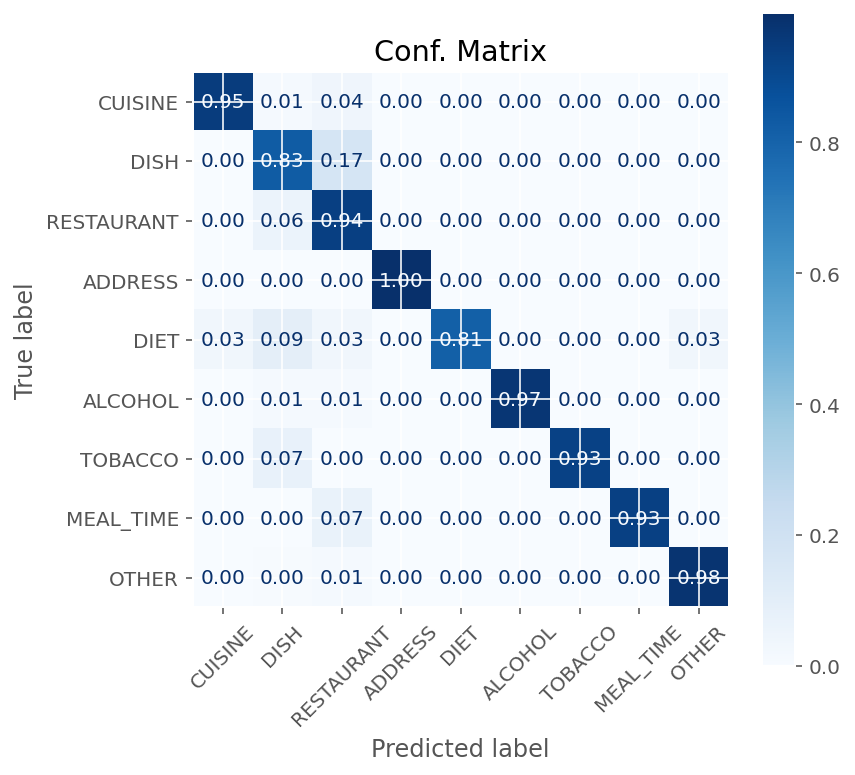

In [171]:
predictor = classifier.predict(train_input_fn(False), yield_single_examples=True)
y_pred_train = np.array([np.argmax(pred['probabilities']) for pred in predictor])
classification_report_TF(y_pred_train, df_train.label, LABEL_SET)


predicted distribution
1    258
2    188
0    43 
3    8  
8    7  
7    4  
5    4  
4    4  
6    3  
dtype: int64
actual distribution
1    253
2    150
8    47 
0    47 
3    6  
7    5  
5    4  
4    4  
6    3  
Name: label, dtype: int64
              precision    recall  f1-score   support

     CUISINE       0.93      0.85      0.89        47
        DISH       0.86      0.88      0.87       253
  RESTAURANT       0.69      0.87      0.77       150
     ADDRESS       0.75      1.00      0.86         6
        DIET       0.75      0.75      0.75         4
     ALCOHOL       1.00      1.00      1.00         4
     TOBACCO       1.00      1.00      1.00         3
   MEAL_TIME       0.75      0.60      0.67         5
       OTHER       0.71      0.11      0.19        47

    accuracy                           0.80       519
   macro avg       0.83      0.78      0.78       519
weighted avg       0.81      0.80      0.78       519



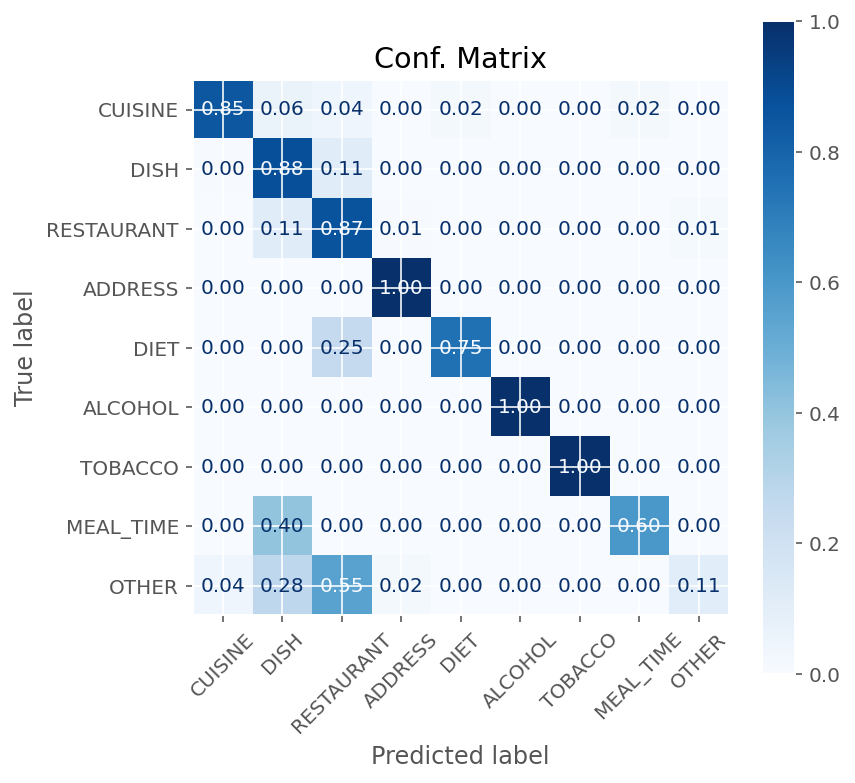

In [172]:
predictor = classifier.predict(test_input_fn, yield_single_examples=True)
y_pred_true = np.array([np.argmax(pred['probabilities']) for pred in predictor])
classification_report_TF(y_pred_true, df_test.label, LABEL_SET)

#### Testing

In [173]:
predictor = classifier.predict(test_input_fn, yield_single_examples=True)
y_pred_true = np.array([np.argmax(pred['probabilities']) for pred in predictor])

df_test['pred']=y_pred_true
df_test['match'] = df_test["label"]==df_test["pred"]
df_test[df_test.match==True]

,query,intent,label,pred,match
0,pizza,DISH,1,1,True
1,chinese,CUISINE,0,0,True
2,salad,DISH,1,1,True
4,1211 algeria ave,ADDRESS,3,3,True
5,601 n broadway denver co 80204,ADDRESS,3,3,True
6,845 clermont st,ADDRESS,3,3,True
7,harvard ave l,ADDRESS,3,3,True
8,thai 60614,ADDRESS,3,3,True
9,alcohol,ALCOHOL,5,5,True
10,american,CUISINE,0,0,True


## Deployment



1. Seralize TF Graph
1. Deseralize Graph (either sideload or TF Serving)

### Seralize Graph

Export the TF Graph to the SavedModel format for downstream usage.

In [174]:
np.set_printoptions(suppress=True, precision=2)

In [175]:
def serving_input_receiver_fn():
    """A function that takes no argument and returns a
    `tf.estimator.export.ServingInputReceiver"""
    
    #1 parse the proto w/ the query string
    #2 tokenize the query as "query"
    #3 embedding picks up "query"
    
    serialized_tf_example = tf.placeholder(
            dtype=tf.string,
            shape=[None],
            name='input_example_tensor')
    receiver_tensors = {"examples": serialized_tf_example}
    feature_spec = {'query': tf.FixedLenFeature([], tf.string, default_value='')}
    examples = tf.parse_example(serialized_tf_example, feature_spec)
    
    queries = examples["query"]
    case_folding = tf.strings.lower(queries)
    masked_strings = tf.strings.regex_replace(case_folding, "\s", "_")
    
    word_tokens = tf.strings.split(case_folding) #WORDS
    tokens = tf.string_split(masked_strings, "") #CHARS
    with tf.device('/CPU'):
        ngrams = tft.ngrams(tokens, (1,3), "")
    
    features = {'tokens': ngrams, "slen": tf.strings.length(queries), "word_tokens": word_tokens}
    
    sir = tf.estimator.export.ServingInputReceiver(features, receiver_tensors)
    return sir



In [176]:
export_path = classifier.export_saved_model("exports/estimators/", serving_input_receiver_fn)
export_path = export_path.decode()
print(export_path)

exports/estimators/1596141568


In [177]:
!saved_model_cli show --dir {export_path} --tag_set serve --sig serving_default

W0730 20:39:36.729778 139857153718080 module_wrapper.py:139] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

The given SavedModel SignatureDef contains the following input(s):
  inputs['inputs'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: input_example_tensor:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['classes'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 9)
      name: dnn/head/Tile:0
  outputs['scores'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 9)
      name: dnn/head/predictions/probabilities:0
Method name is: tensorflow/serving/classify


### Python Client

In [178]:
from tensorflow.python.saved_model import loader

In [179]:
tag_set = "serve"
saved_model_dir = export_path
output_tensor_names_sorted = ["dnn/head/Tile:0", #dnn/head/Tile:0"
                              "dnn/head/predictions/probabilities:0"] #dnn/head/predictions/probabilities:0"

input_examples = ["taco bell", "taco ball", "KFC", "sushi", "hancos", "le prive", "le rivage", "starbuck coffe",
                 "z", "zz", "zzz", "j", "jj", "asdf", "beer", "juul", "paleo pizza", "pizza", "paleo",
                 "gluten free pizza", "french", "beef bourginion", "mcdonalds", "mcd",
                  "cheesecake", "zzzzzzz", "wine", "vodka", "pizza",
                 "", " ", "mediterian", "jsalfjsalfkj", "carnitas snack shack", "panera", "wine", "lunch",
                 "vegan sandwitch", "bhel puri", "french", "frennch", "crench", "frennc"]
proto_str = make_examples(input_examples, "query")
inputs_feed_dict = {"input_example_tensor:0": proto_str}

CLASS_NAMES = np.array(LABEL_SET)

with tf.Session(graph=tf.Graph()) as sess:
    loader.load(sess, tag_set.split(','), saved_model_dir)
    outputs = sess.run(output_tensor_names_sorted,
                       feed_dict=inputs_feed_dict)
    for inputs, outputs in zip(input_examples, outputs[1]):
        print("%15s \t %25s\t %s"%(inputs, CLASS_NAMES[np.argmax(outputs)], outputs))
        


      taco bell 	                RESTAURANT	 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
      taco ball 	                RESTAURANT	 [0.   0.37 0.63 0.   0.   0.   0.   0.   0.  ]
            KFC 	                RESTAURANT	 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
          sushi 	                      DISH	 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
         hancos 	                      DISH	 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
       le prive 	                RESTAURANT	 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
      le rivage 	                RESTAURANT	 [0.   0.   0.99 0.   0.   0.   0.   0.   0.  ]
 starbuck coffe 	                RESTAURANT	 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
              z 	                      DISH	 [0.02 0.55 0.06 0.01 0.02 0.01 0.02 0.01 0.32]
             zz 	                      DISH	 [0.01 0.56 0.03 0.   0.   0.   0.   0.   0.4 ]
            zzz 	                     OTHER	 [0.   0.   0.   0.   0.   0.   0.   0.   0.99]
              j 	                     OTHER	 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
             

### Java Client

```java
import org.tensorflow.Graph;
import org.tensorflow.Session;
import org.tensorflow.Tensor;
import org.tensorflow.Tensors;
import org.tensorflow.TensorFlow;
import org.tensorflow.SavedModelBundle;
import org.tensorflow.SavedModelBundle.Loader;
import org.tensorflow.example.*;
import com.google.protobuf.ByteString;
import java.util.Map;
import java.util.Arrays;
import java.util.List;
import java.util.ArrayList;  

public class IntentClf {

  public static void main(String[] args) throws Exception {


      SavedModelBundle bundle = SavedModelBundle.load("../exports/1571070667", "serve");

    Graph graph = bundle.graph();

    String query = "taco bell";
    ByteString byteString = ByteString.copyFrom(query, "ascii");
    BytesList byteList = BytesList.newBuilder().addValue(byteString).build();
    Feature offset = Feature.newBuilder().setBytesList(byteList).build();

    Features features = Features.newBuilder().putFeature("query", offset).build();
    Example example = Example.newBuilder().setFeatures(features).build();
    byte[][] seralized_examples = new byte[1][];
    seralized_examples[0]=example.toByteArray();

    Tensor<String> inputBatch = Tensors.create(seralized_examples);

    final String input_tensor = "input_example_tensor";
    final String output_tensor = "dnn/head/predictions/probabilities";

    Tensor<Float> result = bundle.session().runner()
          .feed(input_tensor, inputBatch)
          .fetch(output_tensor)
          .run().get(0)
          .expect(Float.class);

    System.out.println(Arrays.deepToString(result.copyTo(new float[1][9])));  //4 b/c this model has 9 classes
  }
}
```

### Publish Module

push w/ pypi repo:

`make release` -> `twine upload --repository pypi dist/*`

In [180]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted Constants.ipynb.
Converted ETL.ipynb.
Converted TF_data.ipynb.
Converted Utils.ipynb.
Converted dask_monkey_patches.ipynb.
Converted fasttext.ipynb.
Converted focal_loss.ipynb.
Converted gibberish_detector.ipynb.
Converted index.ipynb.
Converted versioning tests.ipynb.


## Instrumentalization

We want to retrain the model periodicly, outside of the notebook setting.

Integrate package w/ deployment branch